In [1]:
import sys
sys.path.append("..")

In [2]:
from models import base_model, training_utils, prediction_utils, exp_utils

In [3]:
import torch
import torch_geometric
from torch_geometric.nn import SAGEConv
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data_folder = "/biodata/nyanovsky/datasets/dti/processed/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

node_df = pd.read_csv(data_folder+"dti_tensor_df.csv",index_col=0)
#load data
datasets, node_map = training_utils.load_data(data_folder,load_inverted_map=False,load_test=True)

train_set, val_set, test_set = datasets

In [5]:
# best params till now
train_params = {'weight_decay': 0.001,
 'lr': 0.001,
 'epochs': 400,
 'patience': 10,
 'delta': 0.1,
 'feature_dim': 32}

gral_params = {"pre_process_layers": 1, 
               "post_process_layers":1,
               "hidden_channels":32,
               "batch_norm": False,
               "layer_connectivity":False,
               "dropout":0,
               "macro_aggregation": "mean",
               "L2_norm": True,
               "msg_passing_layers":3,
               "normalize_output":False}

conv_params = {"aggr":"sum"}

In [6]:
model = base_model.base_model(SAGEConv, gral_params, conv_params, train_set.metadata(), [("gene", "chg", "chem")])

train,val, test = exp_utils.init_features(train_set, val_set, test_set, train_params)

/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/users/nyanovsky/miniconda3/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
model, val_auc, curves  = exp_utils.train_model(model, train_params, train, val)

In [9]:
val_auc

0.928

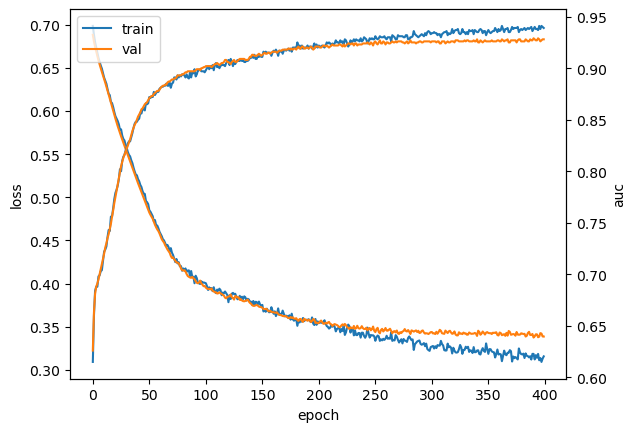

In [64]:
epochs = 400
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(list(range(epochs)), curves[0], label="train")
ax1.plot(list(range(epochs)), curves[1], label="val")

ax2.plot(list(range(epochs)), curves[2], label="train")
ax2.plot(list(range(epochs)), curves[3], label="val")

ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax2.set_ylabel("auc")
plt.legend()
plt.show()


In [14]:
model.to("cpu")

base_model(
  (encoder): base_encoder(
    (pre_mlp): hetero_MLP(
      (mlps): ModuleDict(
        (chem): MLP(
          (model): Sequential(
            (0): Linear(in_features=32, out_features=32, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
          )
        )
        (gene): MLP(
          (model): Sequential(
            (0): Linear(in_features=32, out_features=32, bias=True)
            (1): LeakyReLU(negative_slope=0.01)
          )
        )
      )
    )
    (message_passing): msg_passing(
      (layers): ModuleList(
        (0-2): 3 x GraphModule(
          (conv): ModuleDict(
            (chem__chg__gene): SAGEConv(-1, 32, aggr=sum)
            (chem__chch__chem): SAGEConv(-1, 32, aggr=sum)
            (gene__gg__gene): SAGEConv(-1, 32, aggr=sum)
            (gene__chg__chem): SAGEConv(-1, 32, aggr=sum)
          )
          (post_conv): ModuleList(
            (0): ModuleDict(
              (chem): LeakyReLU(negative_slope=0.01)
              (gene): Leaky

In [15]:
encodings_dict = training_utils.get_encodings(model, test)

predictor = prediction_utils.Predictor(node_df,encodings_dict)

preds = predictor.predict_supervision_edges(test,("gene","chg","chem"))

In [18]:
preds.sort_values(by="score", ascending=False)

,torch_gene_index,torch_chem_index,score,label
251,392,1310,0.997820,1.0
561,393,897,0.997770,1.0
2915,393,2101,0.997270,1.0
1454,392,1351,0.997259,1.0
79,63,1758,0.997244,1.0
...,...,...,...,...
5923,3446,3412,0.000696,0.0
7271,4296,2016,0.000671,0.0
4082,5425,1092,0.000653,0.0
7555,3895,3428,0.000545,0.0


In [19]:
import seaborn as sns

<Axes: ylabel='Count'>

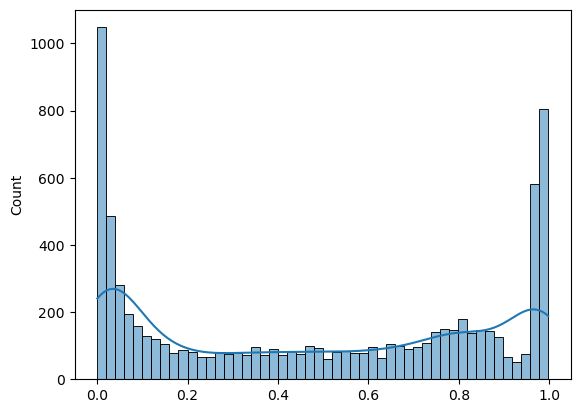

In [22]:
sns.histplot(preds["score"].values, bins=50, kde=True)

In [43]:
gene_node_df = node_df[node_df["node_type"]=="gene"]
chem_node_df = node_df[node_df["node_type"]=="chem"]

def get_chg_deg(nodetype_df, tensor_idx):
    return nodetype_df[nodetype_df["tensor_index"]==tensor_idx]["ChG_deg"].values[0]

preds["total_ChG_deg"] = preds.apply(lambda row: get_chg_deg(gene_node_df, row["torch_gene_index"])+get_chg_deg(chem_node_df, row["torch_chem_index"]),axis=1)

In [48]:
preds_t = preds[preds["label"]==1]
preds_f = preds[preds["label"]==0]

preds_t.sort_values(by="total_ChG_deg", inplace=True)
preds_f.sort_values(by="total_ChG_deg", inplace=True)


/tmp/ipykernel_839208/3377449322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_t.sort_values(by="total_ChG_deg", inplace=True)
/tmp/ipykernel_839208/3377449322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_f.sort_values(by="total_ChG_deg", inplace=True)


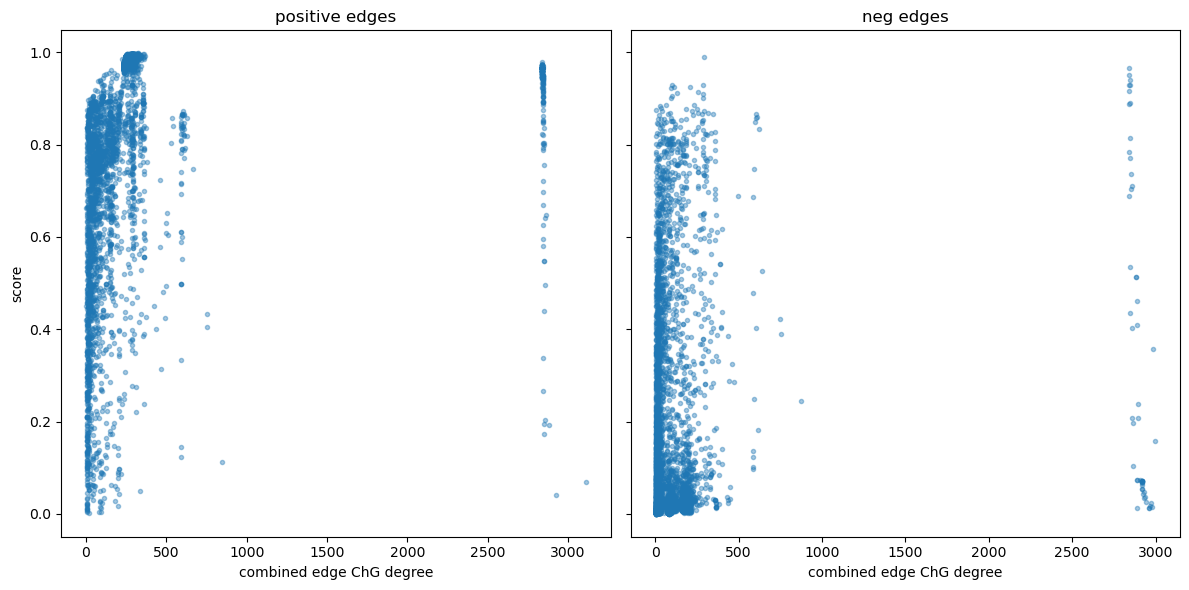

In [91]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12,6))

axes[0].plot(preds_t["total_ChG_deg"], preds_t["score"], ".", alpha=0.4)
axes[0].set_xlabel("combined edge ChG degree")
axes[0].set_ylabel("score")
axes[0].set_title("positive edges")

axes[1].plot(preds_f["total_ChG_deg"], preds_f["score"], ".", alpha=0.4)
axes[1].set_xlabel("combined edge ChG degree")
axes[1].set_title("neg edges")

plt.tight_layout()
plt.show()